# Optimal savings with JAX

#### Prepared for the CBC QuantEcon Workshop (September 2022)

#### John Stachurski

Re-implements the optimal savings problem using JAX.

In [2]:
import numpy as np
import quantecon as qe
import jax
import jax.numpy as jnp
from collections import namedtuple
import matplotlib.pyplot as plt

In [3]:
# Use 64 bit floats with JAX in order to match NumPy/Numba code
jax.config.update("jax_enable_x64", True)

In [4]:
def successive_approx(T,                     # Operator (callable)
                      x_0,                   # Initial condition
                      tolerance=1e-6,        # Error tolerance
                      max_iter=10_000,       # Max iteration bound
                      print_step=25,         # Print at multiples
                      verbose=False):        
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x

-

##  Primitives and Operators 

In [5]:
# A namedtuple definition for storing parameters and grids
Model = namedtuple('Model', 
                    ('β', 'R', 'γ', 'w_grid', 'y_grid', 'Q'))

In [6]:
def create_consumption_model(R=1.01,                    # Gross interest rate
                             β=0.98,                    # Discount factor
                             γ=2.5,                     # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5.0,                 # Max wealth
                             w_size=150,                # Grid side
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns an instance of Model that
    contains data for the optimal savings problem.
    """
    w_grid = np.linspace(w_min, w_max, w_size)  
    mc = qe.tauchen(ρ, ν, n=y_size)
    y_grid, Q = np.exp(mc.state_values), mc.P
    return Model(β=β, R=R, γ=γ, w_grid=w_grid, y_grid=y_grid, Q=Q)

In [7]:
def create_consumption_model_jax():
    "Build a JAX-compatible version of the consumption model."

    model = create_consumption_model()
    β, R, γ, w_grid, y_grid, Q = model

    # Break up parameters into static and nonstatic components
    constants = β, R, γ
    sizes = len(w_grid), len(y_grid)
    arrays = w_grid, y_grid, Q

    # Shift arrays to the device (e.g., GPU)
    arrays = tuple(map(jax.device_put, arrays))
    return constants, sizes, arrays

In [8]:
def B(v, constants, sizes, arrays):
    """
    A vectorized version of the right-hand side of the Bellman equation 
    (before maximization), which is a 3D array representing

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    for all (w, y, w′).
    """

    # Unpack 
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Compute current rewards r(w, y, wp) as array r[i, j, ip]
    w  = jnp.reshape(w_grid, (w_size, 1, 1))    # w[i]   ->  w[i, j, ip]
    y  = jnp.reshape(y_grid, (1, y_size, 1))    # z[j]   ->  z[i, j, ip]
    wp = jnp.reshape(w_grid, (1, 1, w_size))    # wp[ip] -> wp[i, j, ip]
    c = R * w + y - wp

    # Calculate continuation rewards at all combinations of (w, y, wp)
    v = jnp.reshape(v, (1, 1, w_size, y_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = jnp.reshape(Q, (1, y_size, 1, y_size))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = jnp.sum(v * Q, axis=3)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -np.inf)

In [9]:
def compute_r_σ(σ, constants, sizes, arrays):
    """
    Compute the array r_σ[i, j] = r[i, j, σ[i, j]], which gives current
    rewards given policy σ.
    """

    # Unpack model
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Compute r_σ[i, j]
    w = jnp.reshape(w_grid, (w_size, 1))
    y = jnp.reshape(y_grid, (1, y_size))
    wp = w_grid[σ]
    c = R * w + y - wp
    r_σ = c**(1-γ)/(1-γ)

    return r_σ

In [10]:
def T(v, constants, sizes, arrays):
    "The Bellman operator."
    return jnp.max(B(v, constants, sizes, arrays), axis=2)

In [11]:
def get_greedy(v, constants, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, constants, sizes, arrays), axis=2)

In [12]:
def T_σ(v, σ, constants, sizes, arrays):
    "The σ-policy operator."

    # Unpack model
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    r_σ = compute_r_σ(σ, constants, sizes, arrays)

    # Compute the array v[σ[i, j], jp]
    yp_idx = jnp.arange(y_size)
    yp_idx = jnp.reshape(yp_idx, (1, 1, y_size))
    σ = jnp.reshape(σ, (w_size, y_size, 1))
    V = v[σ, yp_idx]      

    # Convert Q[j, jp] to Q[i, j, jp] 
    Q = jnp.reshape(Q, (1, y_size, y_size))

    # Calculate the expected sum Σ_jp v[σ[i, j], jp] * Q[i, j, jp]
    Ev = np.sum(V * Q, axis=2)

    return r_σ + β * np.sum(V * Q, axis=2)

In [13]:
def R_σ(v, σ, constants, sizes, arrays):
    """
    The value v_σ of a policy σ is defined as 

        v_σ = (I - β P_σ)^{-1} r_σ

    Here we set up the linear map v -> R_σ v, where R_σ := I - β P_σ. 

    In the consumption problem, this map can be expressed as

        (R_σ v)(w, y) = v(w, y) - β Σ_y′ v(σ(w, y), y′) Q(y, y′)

    Defining the map as above works in a more intuitive multi-index setting
    (e.g. working with v[i, j] rather than flattening v to a one-dimensional
    array) and avoids instantiating the large matrix P_σ.

    """

    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(y_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, y_size))
    σ = jnp.reshape(σ, (w_size, y_size, 1))
    V = v[σ, zp_idx]

    # Expand Q[j, jp] to Q[i, j, jp]
    Q = jnp.reshape(Q, (1, y_size, y_size))

    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Q[j, jp]
    return v - β * np.sum(V * Q, axis=2)

In [14]:
def get_value(σ, constants, sizes, arrays):
    "Get the value v_σ of policy σ by inverting the linear map R_σ."

    # Unpack 
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    r_σ = compute_r_σ(σ, constants, sizes, arrays)

    # Reduce R_σ to a function in v
    partial_R_σ = lambda v: R_σ(v, σ, constants, sizes, arrays)

    return jax.scipy.sparse.linalg.bicgstab(partial_R_σ, r_σ)[0]

## JIT compiled versions

In [15]:
B = jax.jit(B, static_argnums=(2,))
compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))
T = jax.jit(T, static_argnums=(2,))
get_greedy = jax.jit(get_greedy, static_argnums=(2,))

In [16]:
get_value = jax.jit(get_value, static_argnums=(2,))

In [17]:
T_σ = jax.jit(T_σ, static_argnums=(3,))
R_σ = jax.jit(R_σ, static_argnums=(3,))

##  Solvers

In [18]:
def value_iteration(model, tol=1e-5):
    "Implements VFI."

    constants, sizes, arrays = model
    _T = lambda v: T(v, constants, sizes, arrays)
    vz = jnp.zeros(sizes)

    v_star = successive_approx(_T, vz, tolerance=tol)
    return get_greedy(v_star, constants, sizes, arrays)

In [22]:
def policy_iteration(model):
    "Howard policy iteration routine."
    constants, sizes, arrays = model
    vz = jnp.zeros(sizes)
    σ = jnp.zeros(sizes, dtype=int)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ, constants, sizes, arrays)
        σ_new = get_greedy(v_σ, constants, sizes, arrays)
        error = jnp.max(np.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")
    return σ

In [23]:
def optimistic_policy_iteration(model, tol=1e-5, m=10):
    "Implements the OPI routine."
    constants, sizes, arrays = model
    v = jnp.zeros(sizes)
    error = tol + 1
    while error > tol:
        last_v = v
        σ = get_greedy(v, constants, sizes, arrays)
        for _ in range(m):
            v = T_σ(v, σ, constants, sizes, arrays)
        error = jnp.max(np.abs(v - last_v))
    return get_greedy(v, constants, sizes, arrays)

## Plots

Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.


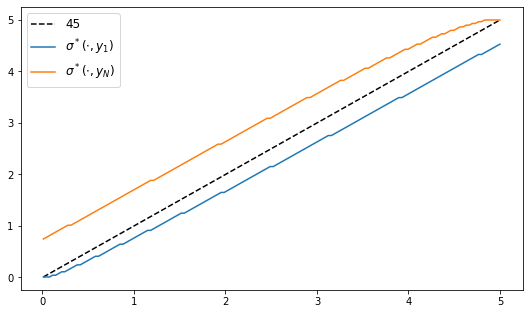

In [24]:
fontsize=12
model = create_consumption_model_jax()
# Unpack 
constants, sizes, arrays = model
β, R, γ = constants
w_size, y_size = sizes
w_grid, y_grid, Q = arrays
σ_star = policy_iteration(model)
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star[:, 1]], label="$\\sigma^*(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star[:, -1]], label="$\\sigma^*(\cdot, y_N)$")
ax.legend(fontsize=fontsize)
plt.show()

## Tests

In [25]:
model = create_consumption_model_jax()

In [26]:
print("Starting HPI.")
qe.tic()
out = policy_iteration(model)
elapsed = qe.toc()
print(out)
print(f"HPI completed in {elapsed} seconds.")

Starting HPI.
Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
TOC: Elapsed: 0:00:0.08
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
HPI completed in 0.08285021781921387 seconds.


In [27]:
print("Starting VFI.")
qe.tic()
out = value_iteration(model)
elapsed = qe.toc()
print(out)
print(f"VFI completed in {elapsed} seconds.")

Starting VFI.
TOC: Elapsed: 0:00:0.98
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
VFI completed in 0.9897737503051758 seconds.


In [28]:
print("Starting OPI.")
qe.tic()
out = optimistic_policy_iteration(model, m=100)
elapsed = qe.toc()
print(out)
print(f"OPI completed in {elapsed} seconds.")

Starting OPI.
TOC: Elapsed: 0:00:0.35
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
OPI completed in 0.35640859603881836 seconds.


Running Howard policy iteration.
Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
TOC: Elapsed: 0:00:0.08
PI completed in 0.08228302001953125 seconds.
Running value function iteration.
TOC: Elapsed: 0:00:0.83
VFI completed in 0.8353698253631592 seconds.
Running optimistic policy iteration with m=5.
TOC: Elapsed: 0:00:0.29
OPI with m=5 completed in 0.2976205348968506 seconds.
Running optimistic policy iteration with m=105.
TOC: Elapsed: 0:00:0.14
OPI with m=105 completed in 0.14117431640625 seconds.
Running optimistic policy iteration with m=205.
TOC: Elapsed: 0:00:0.22
OPI with m=205 completed in 0.22847247123718262 seconds.
Running optimistic policy iteration with m=305.
TOC: Elapsed: 0:00:0.33
OPI with m=305 completed in 0.3304746150970459 seconds.
Runni

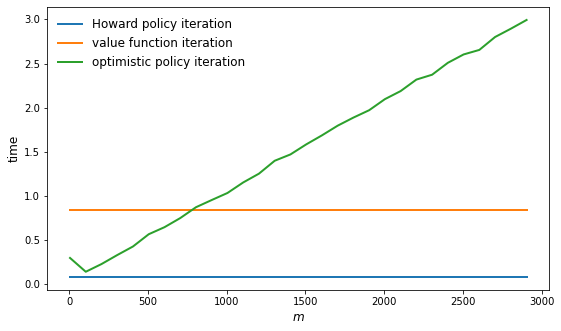

In [29]:
m_vals = range(5, 3000, 100)
model = create_consumption_model_jax()
print("Running Howard policy iteration.")
qe.tic()
σ_pi = policy_iteration(model)
pi_time = qe.toc()
print(f"PI completed in {pi_time} seconds.")

print("Running value function iteration.")
qe.tic()
σ_vfi = value_iteration(model, tol=1e-5)
vfi_time = qe.toc()
print(f"VFI completed in {vfi_time} seconds.")

opi_times = []
for m in m_vals:
    qe.tic()
    σ_opi = optimistic_policy_iteration(model, m=m, tol=1e-5)
    opi_time = qe.toc()
    print(f"OPI with m={m} completed in {opi_time} seconds.")
    opi_times.append(opi_time)
    
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(m_vals, np.full(len(m_vals), pi_time), 
        lw=2, label="Howard policy iteration")
ax.plot(m_vals, np.full(len(m_vals), vfi_time), 
        lw=2, label="value function iteration")
ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
ax.legend(fontsize=fontsize, frameon=False)
ax.set_xlabel("$m$", fontsize=fontsize)
ax.set_ylabel("time", fontsize=fontsize)
plt.show()